# Q-Learning Algorithm

This assignment will review the Q-learning algorithm and the e-greedy approach. You have to update the Qlearning class below to implement these algorithms. The parts of code that need to be changed as labelled as TODOs in the comments.

All your answers should be written in this notebook. You shouldn’t need to write or modify any other files. You should execute every block of code to not miss any dependency.

At the end of the notebook you will find a set of questions to test your understanding of the algorithm.

The experiments use the [FrozenLake](https://gymnasium.farama.org/environments/toy_text/frozen_lake/)
environment from the reinforcement learning [Gymnasium](https://gymnasium.farama.org/)

![frozenlake](https://gymnasium.farama.org/_images/frozen_lake.gif)

## Dependencies & Parameters

Here we import some needed libraries and define the parameters of the Frozenlake environment and the learning process.

Notice that it also creates a directory to store the created figures.


In [34]:
from pathlib import Path
from typing import NamedTuple
from tqdm import tqdm

import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map

from misc import *

sns.set_theme()
%matplotlib inline

class Params(NamedTuple):
    total_episodes: int  # Total episodes
    learning_rate: float  # Learning rate
    gamma: float  # Discounting rate
    epsilon: float  # Exploration probability
    map_size: int  # Number of tiles of one side of the squared environment
    seed: int  # Define a seed so that we get reproducible results
    is_slippery: bool  # If true the player will move in intended direction with probability of 1/3 else will move in either perpendicular direction with equal probability of 1/3 in both directions
    n_runs: int  # Number of runs
    action_size: int  # Number of possible actions
    state_size: int  # Number of possible states
    proba_frozen: float  # Probability that a tile is frozen
    savefig_folder: Path  # Root folder where plots are saved


params = Params(
    total_episodes=10000,   #was 2000
    learning_rate=0.4, #was 0.8
    gamma=0.9,  #was 0.95
    epsilon=0.6,    #was 0.1
    map_size=5,
    seed=123,
    is_slippery=False,
    n_runs=20,
    action_size=None,
    state_size=None,
    proba_frozen=0.9,
    savefig_folder=Path("./_static/img"),
)

# Set the seed
rng = np.random.default_rng(params.seed)

# Create the figure folder if it doesn't exist
params.savefig_folder.mkdir(parents=True, exist_ok=True)

# The frozen lake environment
env = gym.make(
    "FrozenLake-v1",
    is_slippery=params.is_slippery,
    render_mode="rgb_array",
    desc=generate_random_map(
        size=params.map_size, p=params.proba_frozen, seed=params.seed
    ),
)

# Qlearning class - UPDATE HERE TO IMPLEMENT Q-LEARNING AND e-GREEDY

In this implementation we use Tabular Q-learning as our learning algorithm and
$\epsilon$-greedy to decide which action to pick at each step.

The **Action-value** function (Q(s,a)) is implemented as a table storing the expected
return for each state,action pair: `qtable[state,action])`. 

We first create our Q-table initialized at zero with the states number as rows and the actions number as columns.

Then, you need to modify `update` to allow the updating of the Q(s,a) function (i.e., the table) according to the Q-learning algorithm, and the `EpsilonGreedy` to allow for the system to exhibit both exploration and exploitation behaviors

You can have a look at the slides or the references below for some refreshers on the theory.


In [35]:
params = params._replace(action_size=env.action_space.n)
params = params._replace(state_size=env.observation_space.n)
print(f"Action size: {params.action_size}")
print(f"State size: {params.state_size}")


class Qlearning:
    def __init__(self, learning_rate, gamma, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.reset_qtable()
        self.qtable = np.zeros((self.state_size, self.action_size))


    def update(self, state, action, reward, new_state):
        """TODO: Change the following code to implement the update of the Q-function
            Q_update(s,a):= Q(s,a) + learning_rate * delta
                delta =  [R(s,a) + gamma * max Q(s',a') - Q(s,a)]"""
        delta = reward + self.gamma * np.max(self.qtable[new_state, :]) - self.qtable[state, action]      
        self.qtable[state, action] += self.learning_rate * delta
        q_update = self.qtable[state, action]
        return q_update

    def reset_qtable(self):
        """Reset the Q-table."""
        self.qtable = np.zeros((self.state_size, self.action_size))


class EpsilonGreedy:
    def __init__(self, epsilon):
        self.epsilon = epsilon

    def choose_action(self, action_space, state, qtable):
        """TODO: Implement the e-greedy algorithm. i.e.:
            with probability epsilon:
                select an action randomly
            else
                select the action with the highest q-value"""
        if np.random.uniform(0, 1) < self.epsilon:
            # Select a random action
            action = action_space.sample()
        else:
            # Select the action with the highest Q-value
            action = np.argmax(qtable[state, :])
        return action

Action size: 4
State size: 25


Let's instantiate the learner and the explorer.




In [36]:
learner = Qlearning(
    learning_rate=params.learning_rate,
    gamma=params.gamma,
    state_size=params.state_size,
    action_size=params.action_size,
)
explorer = EpsilonGreedy(
    epsilon=params.epsilon,
)

In [ ]:
# Running the environment without any learnning

The code below executes all the steps for the agent to interact with the environment, except calling the learning function. As a result, it tests how does an agent with a random policy and no learning would behave 

In [19]:
def run_env_no_learning():
    rewards = np.zeros((params.total_episodes, params.n_runs))
    steps = np.zeros((params.total_episodes, params.n_runs))
    episodes = np.arange(params.total_episodes)
    qtables = np.zeros((params.n_runs, params.state_size, params.action_size))
    all_states = []
    all_actions = []

    for run in range(params.n_runs):  # Run several times to account for stochasticity
        
        for episode in tqdm(
            episodes, desc=f"Run {run}/{params.n_runs} - Episodes", leave=False
        ):
            state = env.reset(seed=params.seed)[0]  # Reset the environment
            step = 0
            done = False
            total_rewards = 0

            while not done:
                action = explorer.choose_action(
                    action_space=env.action_space, state=state, qtable=learner.qtable
                )

                # Log all states and actions
                all_states.append(state)
                all_actions.append(action)

                # Take the action (a) and observe the outcome state(s') and reward (r)
                new_state, reward, terminated, truncated, info = env.step(action)

                done = terminated or truncated

                total_rewards += reward
                step += 1

                # Our new state is state
                state = new_state

            # Log all rewards and steps
            rewards[episode, run] = total_rewards
            steps[episode, run] = step
        qtables[run, :, :] = learner.qtable

    return rewards, steps, episodes, qtables, all_states, all_actions

The code below creates an agent with a random policy, runs the episodes and plots the outcome of the process

In [31]:
all_states = []
all_actions = []

env = gym.make(
"FrozenLake-v1",
is_slippery=params.is_slippery,
render_mode="rgb_array",
desc=generate_random_map(
    size=params.map_size, p=params.proba_frozen, seed=params.seed
),
)

params = params._replace(action_size=env.action_space.n)
params = params._replace(state_size=env.observation_space.n)

env.action_space.seed(
params.seed
)  # Set the seed to get reproducible results when sampling the action space
learner = Qlearning(
learning_rate=params.learning_rate,
gamma=params.gamma,
state_size=params.state_size,
action_size=params.action_size,
)

# Force exploration in every step 
explorer = EpsilonGreedy(
    epsilon=1.0,
)

state = env.reset(seed=params.seed)[0]  # Reset the environment

# Initialize the Q-table with zero values
learner.reset_qtable()

# Generate several trajectories using the Q-function without exploration and plot
# the distribution of states visited and actions taken

# Notice that if the policy directs the agent towards the border of the 
# environment, it will remain stuck at that point

rewards, steps, episodes, qtables, all_states, all_actions = run_env_no_learning()

# Save the results in dataframes
res, st = postprocess(episodes, params, rewards, steps, params.map_size)

# Plot the Q-table
plot_q_values_map(learner.qtable, env, params.map_size, params, img_label='random')

# Plot the state and action distribution
plot_states_actions_distribution(
    states=all_states, actions=all_actions, map_size=params.map_size, params=params, img_label='random'
)

env.close()

NameError: name 'episode' is not defined

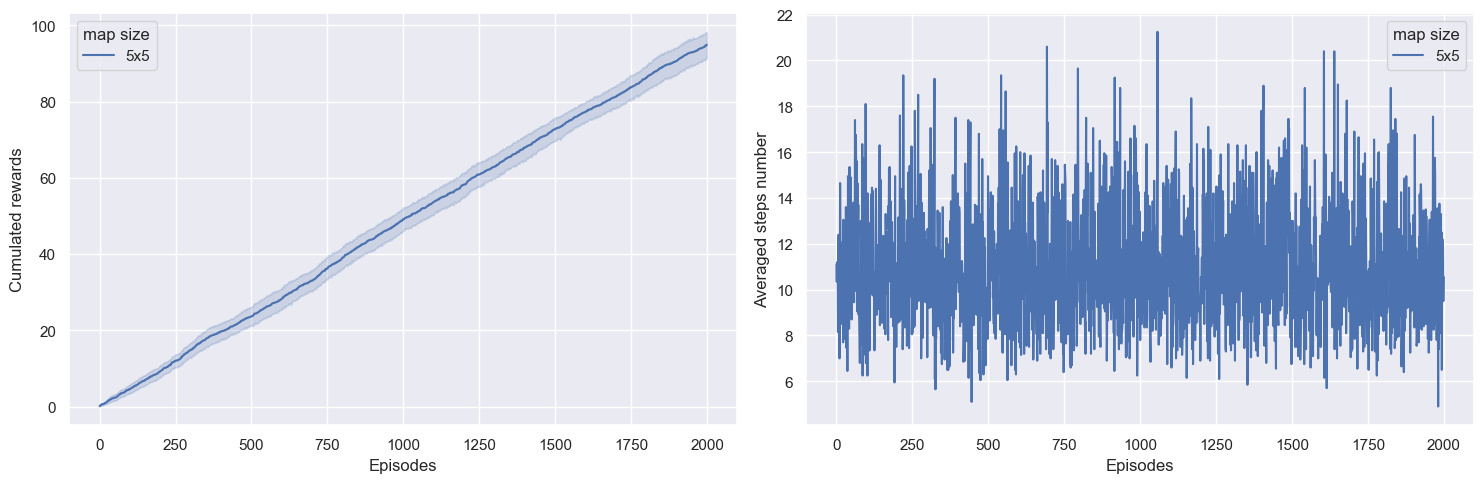

In [6]:
plot_steps_and_rewards(res, st, params)

# Let's apply now the Q-learning algorithm

## Running the environment to learn a strategy

This will be our main function to run our environment and learn the Q-function until the maximum
number of episodes ``params.total_episodes``. To account for
stochasticity, we will also run our environment a few times.




In [37]:
def run_env():
    rewards = np.zeros((params.total_episodes, params.n_runs))
    steps = np.zeros((params.total_episodes, params.n_runs))
    episodes = np.arange(params.total_episodes)
    qtables = np.zeros((params.n_runs, params.state_size, params.action_size))
    all_states = []
    all_actions = []

    for run in range(params.n_runs):  # Run several times to account for stochasticity
        learner.reset_qtable()  # Reset the Q-table between runs

        for episode in tqdm(
            episodes, desc=f"Run {run}/{params.n_runs} - Episodes", leave=False
        ):
            state = env.reset(seed=params.seed)[0]  # Reset the environment
            step = 0
            done = False
            total_rewards = 0

            while not done:
                action = explorer.choose_action(
                    action_space=env.action_space, state=state, qtable=learner.qtable
                )

                # Log all states and actions
                all_states.append(state)
                all_actions.append(action)

                # Take the action (a) and observe the outcome state(s') and reward (r)
                new_state, reward, terminated, truncated, info = env.step(action)

                done = terminated or truncated

                learner.qtable[state, action] = learner.update(
                    state, action, reward, new_state
                )

                total_rewards += reward
                step += 1

                # Our new state is state
                state = new_state

            # Log all rewards and steps
            rewards[episode, run] = total_rewards
            steps[episode, run] = step
        qtables[run, :, :] = learner.qtable

    return rewards, steps, episodes, qtables, all_states, all_actions

# Explore the environment to learn the Value function using Q-learning


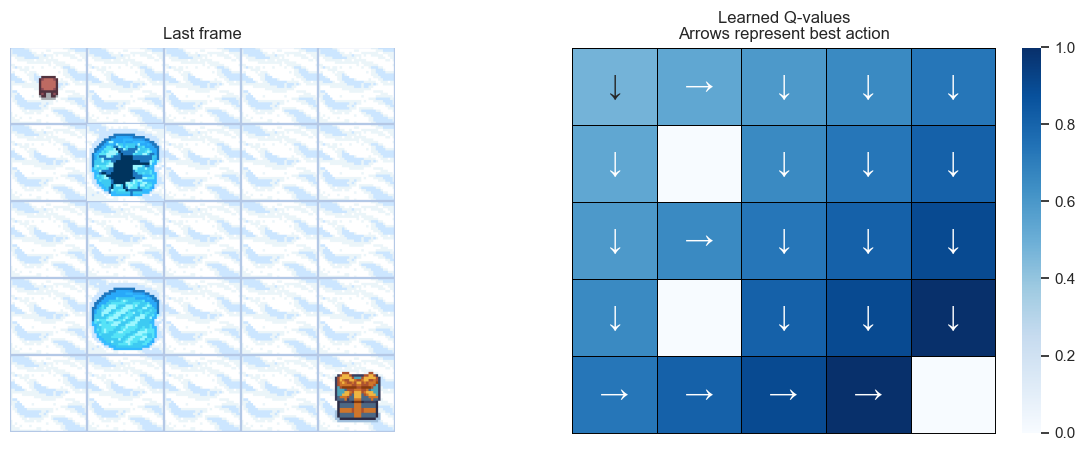

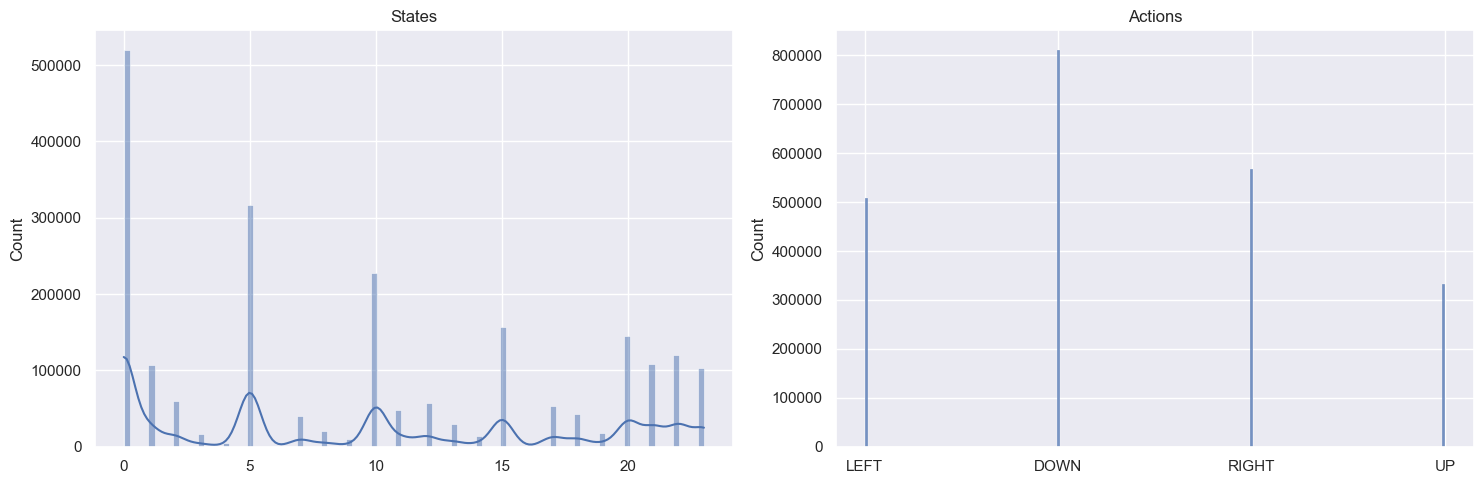

In [38]:
env = gym.make(
    "FrozenLake-v1",
    is_slippery=params.is_slippery,
    render_mode="rgb_array",
    desc=generate_random_map(
        size=params.map_size, p=params.proba_frozen, seed=params.seed
    ),
)

params = params._replace(action_size=env.action_space.n)
params = params._replace(state_size=env.observation_space.n)
env.action_space.seed(
    params.seed
)  # Set the seed to get reproducible results when sampling the action space
learner = Qlearning(
    learning_rate=params.learning_rate,
    gamma=params.gamma,
    state_size=params.state_size,
    action_size=params.action_size,
)
explorer = EpsilonGreedy(
    epsilon=params.epsilon,
)

rewards, steps, episodes, qtables, all_states, all_actions = run_env()

# Save the results in dataframes
res, st = postprocess(episodes, params, rewards, steps, params.map_size)
qtable = qtables.mean(axis=0)  # Average the Q-table between runs

# Plot the Q-table
plot_q_values_map(qtable, env, params.map_size, params=params, img_label='learned')

# Plot the state and action distribution
plot_states_actions_distribution(
    states=all_states, actions=all_actions, map_size=params.map_size, params=params, img_label='learned'
)

env.close()

To check if our agent is learning, we can plot the cumulated sum of
rewards, as well as the number of steps needed until the end of the
episode. If our agent is learning, we expect to see the cumulated sum of
rewards to increase and the number of steps to solve the task to
decrease.




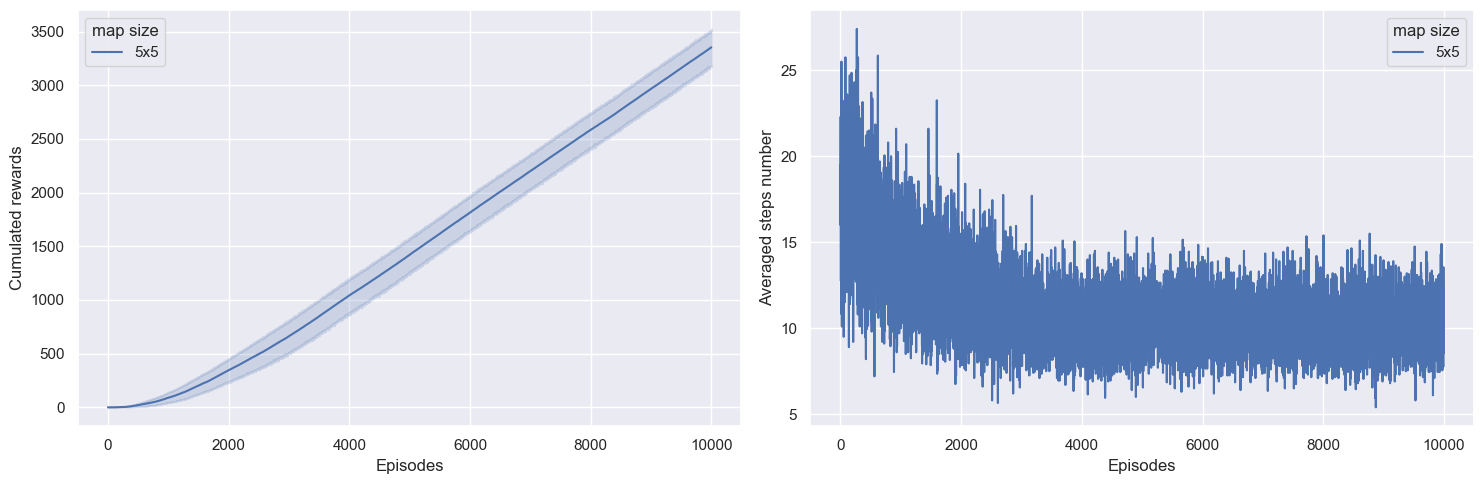

In [39]:
plot_steps_and_rewards(res, st, params)

# Questions:
1. Is the agent able to learn the right policy using Q-learning?
    Yes
2. Why does the cumulated reward increases even when we use a random policy and no learning?
    Because the agent is exploring the environment and trying to find the best path to the goal.
3. Evaluate different values of the alpha, gamma and epsilon hyperparameters to assess their effect in the learning
    The learning process is faster with a higher alpha and gamma and a lower epsilon.
4. Change the size of the environment to 11x11 and compare the learning process
    
5. Change the parameter is_slippery to TRUE to see how it impacts the learning

## References

-  Code inspired from [Deep Reinforcement Learning
   Course](https://simoninithomas.github.io/Deep_reinforcement_learning_Course/)_
   by Thomas Simonini (http://simoninithomas.com/)
-  [Dissecting Reinforcement
   Learning-Part.2](https://mpatacchiola.github.io/blog/2017/01/15/dissecting-reinforcement-learning-2.html)_
-  [Dadid Silver’s course](https://www.davidsilver.uk/teaching/)_ in
   particular lesson 4 and lesson 5
-  [Q-learning article on
   Wikipedia](https://en.wikipedia.org/wiki/Q-learning)_
-  [Q-Learning: Off-Policy TD
   Control](http://incompleteideas.net/book/ebook/node65.html)_ in
   [Reinforcement Learning: An Introduction, by Richard S. Sutton and
   Andrew G. Barto](http://incompleteideas.net/book/ebook/)_
-  [Epsilon-Greedy
   Q-learning](https://www.baeldung.com/cs/epsilon-greedy-q-learning)_
-  [Introduction to Reinforcement
   Learning](https://gibberblot.github.io/rl-notes/index.html)_ by Tim
   Miller (University of Melbourne)

